In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
# from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

In [3]:
df=pd.read_csv(r"C:\Users\fahad\Desktop\work\leak\TRACK_AJJ-O10AT_History.csv")

In [4]:
df['LastActivity'] = pd.to_datetime(df['LastActivity'], errors='coerce')
df['Feed Current (mA)'] = pd.to_numeric(df['Feed Current (mA)'], errors='coerce')
df['Relay Current (mA)'] = pd.to_numeric(df['Relay Current (mA)'], errors='coerce')

In [5]:
columns_to_drop = ['Track Status (null)', 'Energization%',
                   'Charger Status', 'Relay Voltage (v)', 'Track Status (null).1',
                   'Charger Output (v)', 'Feed Voltage (v)', 'Energization (null)',
                   'Outdoor TPR (v)', 'Charger Current (mA)', 'Indoor TPR (v)',
                   'Charger I/P Voltage (v)','Choke (v)']

In [6]:
df = df.drop(columns=columns_to_drop)

In [7]:
df = df.dropna(subset=['Feed Current (mA)', 'Relay Current (mA)'], how='all')
print(df)

                  LastActivity  Feed Current (mA)  Relay Current (mA)
0      2024-06-19 23:59:41.039              692.0                 NaN
1      2024-06-19 23:58:39.008              692.0                 NaN
2      2024-06-19 23:57:45.531                NaN                 0.0
3      2024-06-19 23:57:36.675              692.0                 NaN
4      2024-06-19 23:56:38.452              693.0                 NaN
...                        ...                ...                 ...
112608 2024-04-08 16:24:13.480              319.0                 NaN
112609 2024-04-08 16:23:11.339              319.0                 NaN
112610 2024-04-08 16:22:09.138              319.0                 NaN
112611 2024-04-08 16:21:06.946              319.0                 NaN
112612 2024-04-08 16:20:04.753              318.0                 NaN

[112613 rows x 3 columns]


In [8]:
df.fillna(0,inplace=True)

In [9]:
def plotting(title,data,x,y,x_label,y_label):
  fig = px.line(data,x=data[x],y=data[y],labels={'x':x_label,'y':y_label})
  fig.update_layout(template="simple_white",font=dict(size=18),title_text=title,width=600,title_x=0.5,height=650)
  return fig.show()

In [10]:
plotting("Feed Current (mA)",df,'LastActivity','Relay Current (mA)','Last Activity','Feed Current (mA)')

In [11]:
df_feed = df[['LastActivity', 'Feed Current (mA)']]
df_relay = df[['LastActivity', 'Relay Current (mA)']]

In [12]:
print(df_feed.shape)
print(df_relay.shape)

(112613, 2)
(112613, 2)


In [13]:
# plotting("Feed Current (mA)",df,'LastActivity','Feed Current (mA)','Last Activity','Feed Current (mA)')
# plotting("Relay Current (mA)",df,'LastActivity','Relay Current (mA)','Last Activity','Feed Current (mA)')

In [14]:
df_feed['Date'] = df_feed['LastActivity'].dt.date
df_feed['Hour'] = df_feed['LastActivity'].dt.hour

df_relay['Date'] = df_relay['LastActivity'].dt.date
df_relay['Hour'] = df_relay['LastActivity'].dt.hour

In [15]:
# hourly averages
feed_hourly_avg = df_feed.groupby(['Date', 'Hour'])['Feed Current (mA)'].mean().reset_index()
relay_hourly_avg = df_relay.groupby(['Date', 'Hour'])['Relay Current (mA)'].mean().reset_index()

In [16]:
# Rename columns
feed_hourly_avg.rename(columns={'Feed Current (mA)': 'Feed Current Hourly Avg (mA)'}, inplace=True)
relay_hourly_avg.rename(columns={'Relay Current (mA)': 'Relay Current Hourly Avg (mA)'}, inplace=True)

In [17]:
# Merge the two dataframes
merged_df = pd.merge(feed_hourly_avg, relay_hourly_avg, on=['Date', 'Hour'], how='inner')

merged_df['Leakage'] = merged_df['Feed Current Hourly Avg (mA)'] - merged_df['Relay Current Hourly Avg (mA)']
#adding a timestamp column
merged_df['Timestamp'] = pd.to_datetime(merged_df['Date'].astype(str) + ' ' + merged_df['Hour'].astype(str) + ':00:00')
print(merged_df)

            Date  Hour  Feed Current Hourly Avg (mA)  \
0     2024-04-08    16                    269.934783   
1     2024-04-08    17                    262.536232   
2     2024-04-08    18                    277.194805   
3     2024-04-08    19                    257.027778   
4     2024-04-08    20                    267.632353   
...          ...   ...                           ...   
1688  2024-06-19    19                    273.220588   
1689  2024-06-19    20                    313.855263   
1690  2024-06-19    21                    293.811765   
1691  2024-06-19    22                    510.178082   
1692  2024-06-19    23                    572.246377   

      Relay Current Hourly Avg (mA)     Leakage           Timestamp  
0                         45.673913  224.260870 2024-04-08 16:00:00  
1                         52.391304  210.144928 2024-04-08 17:00:00  
2                         50.792208  226.402597 2024-04-08 18:00:00  
3                         59.500000  197.527778

In [18]:
print(feed_hourly_avg.shape)
print(relay_hourly_avg.shape)

(1693, 3)
(1693, 3)


In [19]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

In [20]:
filter_df = merged_df.loc[(merged_df["Feed Current Hourly Avg (mA)"] <450) & (merged_df["Relay Current Hourly Avg (mA)"]>50)]

In [21]:
fig4 = go.Figure()

fig4.add_trace(
    go.Scatter(
        x=merged_df['Timestamp'],
        y=merged_df['Feed Current Hourly Avg (mA)'],
        mode='lines',
        name='Feed Current (FC)'
    )
)

fig4.add_trace(
    go.Scatter(
        x=merged_df['Timestamp'],
        y=merged_df['Relay Current Hourly Avg (mA)'],
        mode='lines',
        name='Relay Current (RC)'
    )
)

fig4.update_layout(
    title='FC and RC Last Activity Plot',
    xaxis_title='Timestamp',
    yaxis_title='Values',
    hovermode='x unified',
    template='plotly_dark'
)

fig4.show()


In [22]:
fig5 = go.Figure()

fig5.add_trace(
    go.Scatter(
        x=filter_df['Timestamp'],
        y=filter_df['Leakage'],
        mode='lines',
        name='Leakage'
    )
)

fig5.update_layout(
    title='Leakage Last Activity Plot',
    xaxis_title='Timestamp',
    yaxis_title='Values',
    hovermode='x unified',
    # template='plotly_dark'
)
fig5.show()

In [23]:
plotting("Feed Current Hourly Avg (mA)",filter_df,'Timestamp','Feed Current Hourly Avg (mA)','Last Activity','Feed Current Hourly Avg (mA)')
plotting("Relay Current Hourly Avg (mA)",filter_df,'Timestamp','Relay Current Hourly Avg (mA)','Last Activity','Feed Current Hourly Avg (mA)')

In [24]:
filter_df.shape

(464, 6)

In [25]:
filter_df.columns

Index(['Date', 'Hour', 'Feed Current Hourly Avg (mA)',
       'Relay Current Hourly Avg (mA)', 'Leakage', 'Timestamp'],
      dtype='object')

In [26]:
# data up to and including 22 may for training
train_df = filter_df[filter_df['Date'] <= '2024-06-08']

# data after 22 may for testing
test_df = filter_df[filter_df['Date'] > '2024-06-08']

print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Training set shape: (390, 6)
Testing set shape: (74, 6)


In [27]:
decomposition = seasonal_decompose(filter_df['Leakage'], model='multiplicative', period=12)

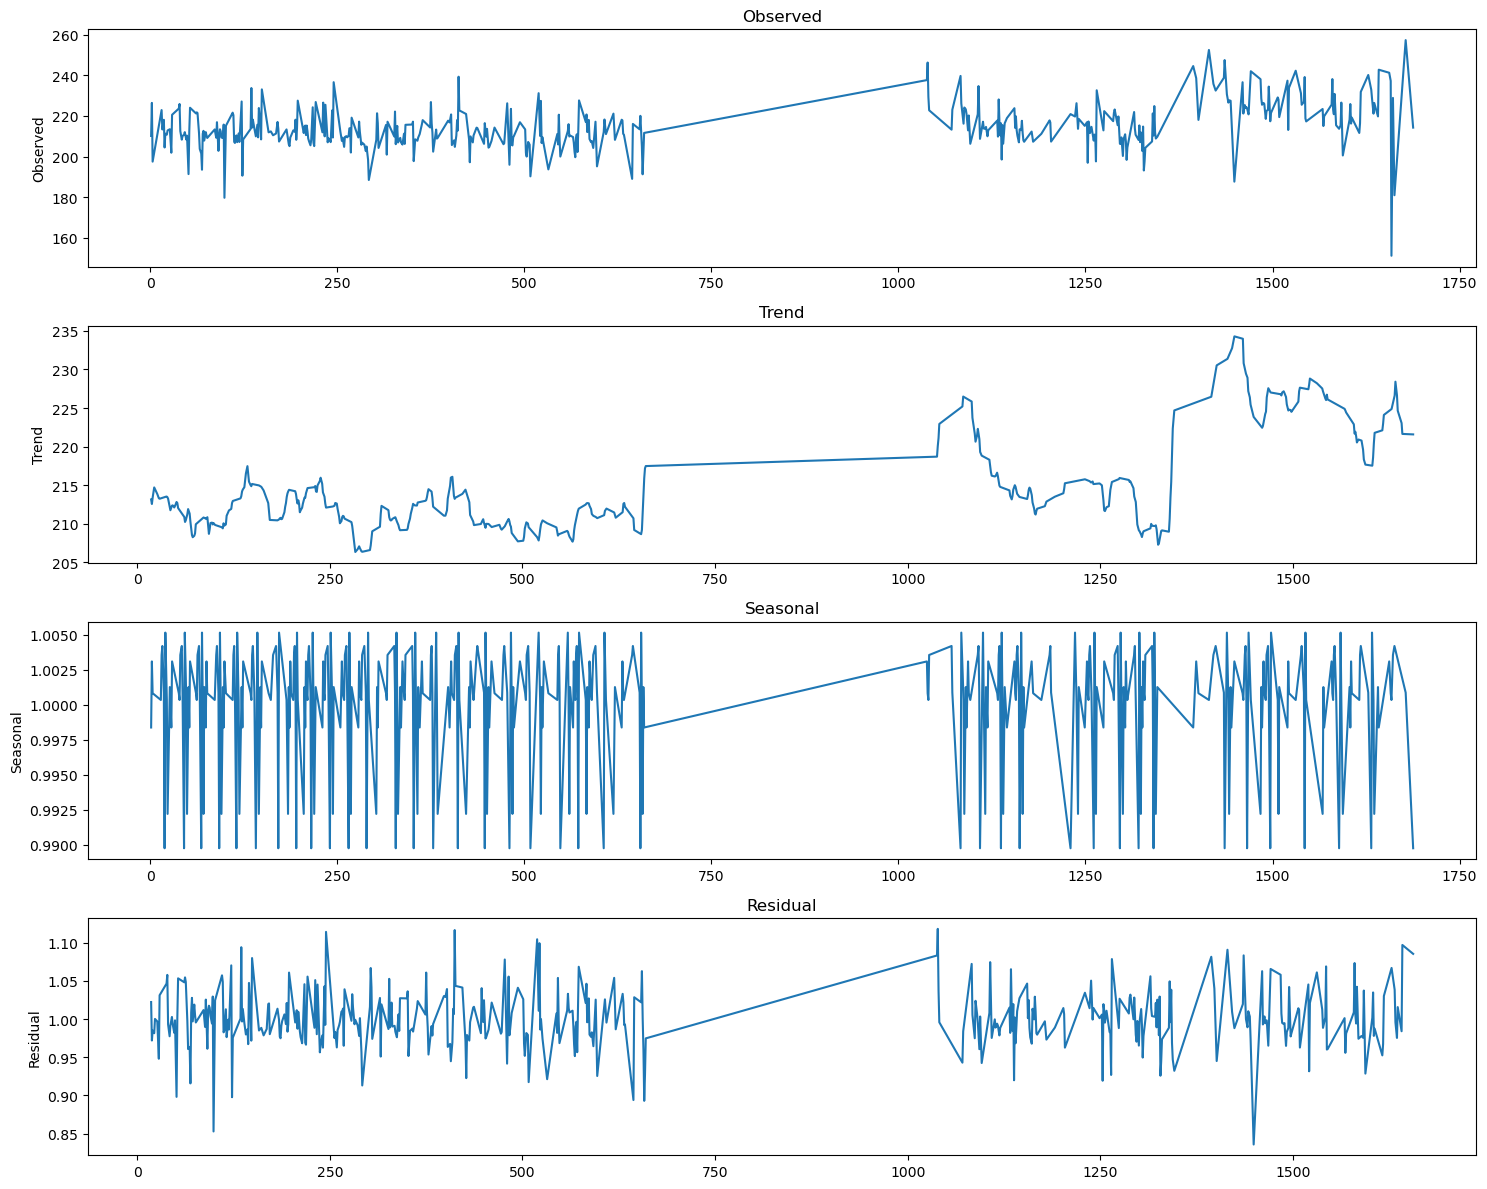

In [28]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=ax1, title='Observed')
ax1.set_ylabel('Observed')

decomposition.trend.plot(ax=ax2, title='Trend')
ax2.set_ylabel('Trend')

decomposition.seasonal.plot(ax=ax3, title='Seasonal')
ax3.set_ylabel('Seasonal')

decomposition.resid.plot(ax=ax4, title='Residual')
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [29]:
# Create subplots
fig = make_subplots(rows=4, cols=1, 
                    subplot_titles=('Observed', 'Trend', 'Seasonal', 'Residual'),
                    vertical_spacing=0.1)

# Add traces for each component
fig.add_trace(go.Scatter(x=filter_df['Timestamp'], y=decomposition.observed, mode='lines', name='Observed'), row=1, col=1)
fig.add_trace(go.Scatter(x=filter_df['Timestamp'][:len(decomposition.trend)], y=decomposition.trend, mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=filter_df['Timestamp'][:len(decomposition.seasonal)], y=decomposition.seasonal, mode='lines', name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=filter_df['Timestamp'][:len(decomposition.resid)], y=decomposition.resid, mode='lines', name='Residual'), row=4, col=1)

# Update layout
fig.update_layout(height=900, width=1200, title_text="Seasonal Decomposition of Time Series")

# Update y-axis labels
fig.update_yaxes(title_text="Observed", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal", row=3, col=1)
fig.update_yaxes(title_text="Residual", row=4, col=1)

# Update x-axis to show date labels
fig.update_xaxes(tickformat="%Y-%m-%d")

# Show the plot
fig.show()

In [30]:
trend_values = decomposition.trend.values
print(trend_values)

[         nan          nan          nan          nan          nan
          nan 213.1586724  212.57187509 213.4154339  214.71607538
 214.4992525  213.85935012 213.31880022 213.2483613  213.53990876
 213.46963388 213.26204015 212.236407   211.76092751 212.34923667
 212.39339648 212.12190561 212.32092215 212.82775721 212.69827324
 212.04843777 210.89441894 210.24335856 210.46065124 211.24546126
 211.91064334 211.32449442 210.25801124 209.40594551 208.55019176
 208.26580612 208.44849196 208.76096214 209.94079718 210.82008289
 210.73294869 210.64930555 210.85770091 209.73160187 208.70122474
 209.29470655 210.0989186  210.1581997  209.91835102 210.09914751
 209.85456151 209.54625915 209.41166166 210.06829552 209.76796974
 209.91483838 211.04354778 211.48328128 211.73384533 211.93392499
 212.68433348 212.96134584 213.29783161 213.5741892  214.19023628
 214.44311075 214.74399628 216.51438667 217.47161858 216.51286176
 215.46686076 215.02557924 214.87566108 215.16447095 214.97575595
 214.79460

In [31]:
trend_values = decomposition.trend.values

trend_df = pd.DataFrame({
    'Timestamp': filter_df['Timestamp'][:len(trend_values)],
    'Trend': trend_values
})
print(trend_df.shape)
print(trend_df.isna().sum())

(464, 2)
Timestamp     0
Trend        12
dtype: int64


In [32]:
trend_df.head(20)

Timestamp       Trend
1  2024-04-08 17:00:00         NaN
2  2024-04-08 18:00:00         NaN
3  2024-04-08 19:00:00         NaN
14 2024-04-09 06:00:00         NaN
15 2024-04-09 07:00:00         NaN
16 2024-04-09 08:00:00         NaN
18 2024-04-09 10:00:00  213.158672
19 2024-04-09 11:00:00  212.571875
20 2024-04-09 12:00:00  213.415434
22 2024-04-09 14:00:00  214.716075
23 2024-04-09 15:00:00  214.499252
26 2024-04-09 18:00:00  213.859350
28 2024-04-09 20:00:00  213.318800
29 2024-04-09 21:00:00  213.248361
38 2024-04-10 06:00:00  213.539909
39 2024-04-10 07:00:00  213.469634
40 2024-04-10 08:00:00  213.262040
42 2024-04-10 10:00:00  212.236407
43 2024-04-10 11:00:00  211.760928
45 2024-04-10 13:00:00  212.349237

In [33]:
trend_df = trend_df.dropna(subset=['Trend'])

In [34]:
fig5 = go.Figure()

fig5.add_trace(
    go.Scatter(
        x=trend_df['Timestamp'],
        y=trend_df['Trend'],
        mode='lines',
        name='Leakage'
    )
)

fig5.update_layout(
    title='Leakage Last Activity Plot',
    xaxis_title='Timestamp',
    yaxis_title='Values',
    hovermode='x unified',
    # template='plotly_dark'
)
fig5.show()

In [35]:
# data up to and including 8 june for training
train = trend_df[trend_df['Timestamp'] <= '2024-06-8']

# data after 8 june for testing
test = trend_df[trend_df['Timestamp'] > '2024-06-8']

print(f"Training set shape: {train.shape}")
print(f"Testing set shape: {test.shape}")

Training set shape: (381, 2)
Testing set shape: (71, 2)


In [36]:
# stepwise_fit = auto_arima(train["Trend"],trace=True,error_action="ignore",suppress_warnings=True)
# stepwise_fit.summary()

ARIMA

In [37]:
model = ARIMA(train['Trend'], order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Trend   No. Observations:                  381
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -455.754
Date:                Tue, 20 Aug 2024   AIC                            917.508
Time:                        13:39:58   BIC                            929.336
Sample:                             0   HQIC                           922.201
                                - 381                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        216.8262      6.539     33.157      0.000     204.009     229.643
ar.L1          0.9939      0.007    146.593      0.000       0.981       1.007
sigma2         0.6331      0.035     18.337      0.0

In [38]:
test_predictions = model_fit.predict(start=len(train['Trend']), end=len(train['Trend']) + len(test['Trend']) - 1, dynamic=True)
test_mse = mean_squared_error(test['Trend'], test_predictions)
print(f'Test Mean Squared Error: {test_mse}')

Test Mean Squared Error: 15.612894746852813


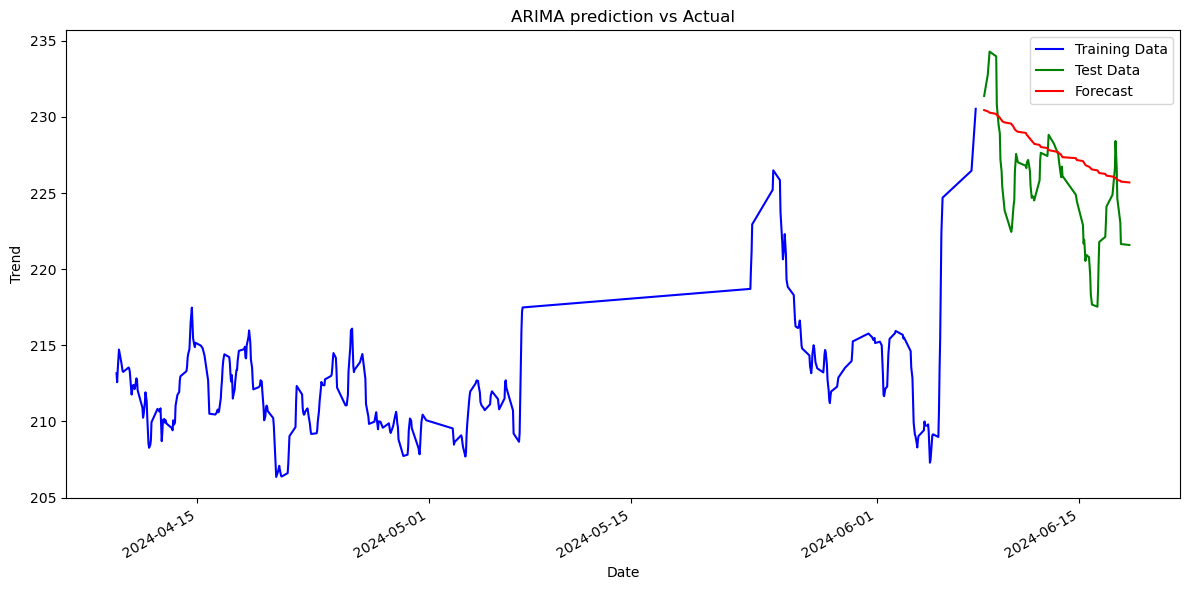

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(train['Timestamp'], train['Trend'], label='Training Data', color='blue')

plt.plot(test['Timestamp'], test['Trend'], label='Test Data', color='green')

plt.plot(test['Timestamp'], test_predictions, label='Forecast', color='red')

plt.title('ARIMA prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend()

fig = plt.gcf()
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

SARIMA

In [40]:
model_trend = SARIMAX(train['Trend'], order=(1,0,1), seasonal_order=(1,1,1, 12))
results = model_trend.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Trend   No. Observations:                  381
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -269.189
Date:                            Tue, 20 Aug 2024   AIC                            548.377
Time:                                    13:40:01   BIC                            567.931
Sample:                                         0   HQIC                           556.145
                                            - 381                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9877      0.012     83.635      0.000       0.965       1.011
ma.L1          1.0000    607.080   

In [41]:
forecasts = results.predict(start=len(train),end=len(train)+len(test)-1)

test_mse2 = mean_squared_error(test['Trend'], forecasts)
print(f'Test Mean Squared Error: {test_mse2}')

Test Mean Squared Error: 20.410086700758086


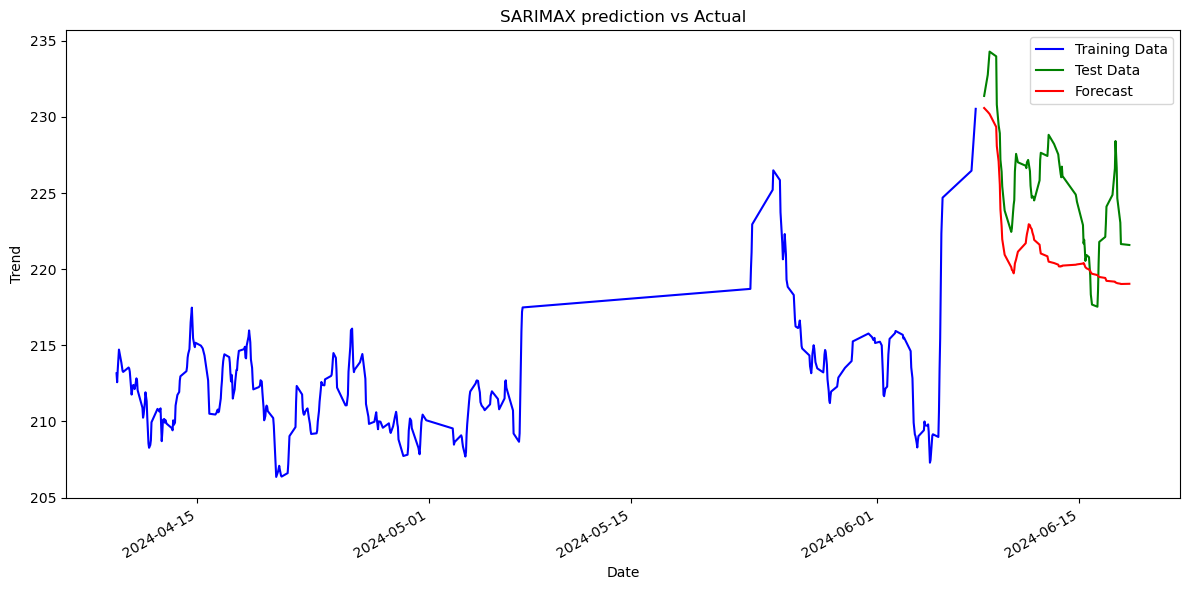

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(train['Timestamp'], train['Trend'], label='Training Data', color='blue')

plt.plot(test['Timestamp'], test['Trend'], label='Test Data', color='green')

plt.plot(test['Timestamp'], forecasts, label='Forecast', color='red')

plt.title('SARIMAX prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend() 

fig = plt.gcf()
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In [43]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [44]:
hw_model=ExponentialSmoothing(train['Trend'],trend='mul',seasonal_periods=12,seasonal='mul').fit(optimized=True)
forcast_hw=hw_model.forecast(len(test))

In [45]:
test_mse = mean_squared_error(test['Trend'], forcast_hw)
print(f'Test Mean Squared Error: {test_mse}')

Test Mean Squared Error: 9576.68469597992


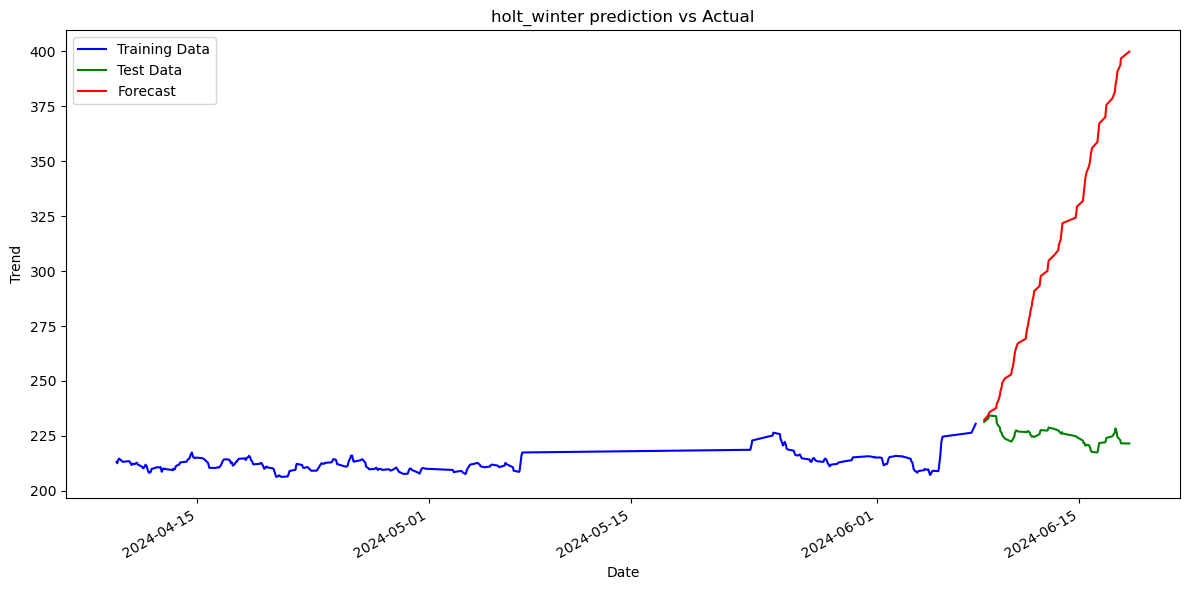

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(train['Timestamp'], train['Trend'], label='Training Data', color='blue')

plt.plot(test['Timestamp'], test['Trend'], label='Test Data', color='green')

plt.plot(test['Timestamp'], forcast_hw, label='Forecast', color='red')

plt.title('holt_winter prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend() 

fig = plt.gcf()
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In [47]:
def plot_forecasts(forecasts :list[float],title : str)->None:
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=train["Timestamp"],y=train["Trend"],name="Train"))
  fig.add_trace(go.Scatter(x=test["Timestamp"],y=test["Trend"],name="Test"))
  fig.add_trace(go.Scatter(x =test["Timestamp"],y=forecasts, name="Forecast"))
  fig.update_layout(template="simple_white",font=dict(size=18),title_text=title,width=650,title_x=0.5,height=400,xaxis_title="Timestamp",yaxis_title="Leakage")
  return fig.show()

In [48]:
plot_forecasts(forcast_hw,'Holt winter model')

SIMPLE EXPONENTIAL MODEL

In [49]:
simple_model = SimpleExpSmoothing(train["Trend"]).fit(optimized = True)
forecaste1 = simple_model.forecast(len(test))

In [50]:
test_mse1 = mean_squared_error(test['Trend'], forecaste1)
print(f'Test Mean Squared Error: {test_mse1}')

Test Mean Squared Error: 41.08420755324803


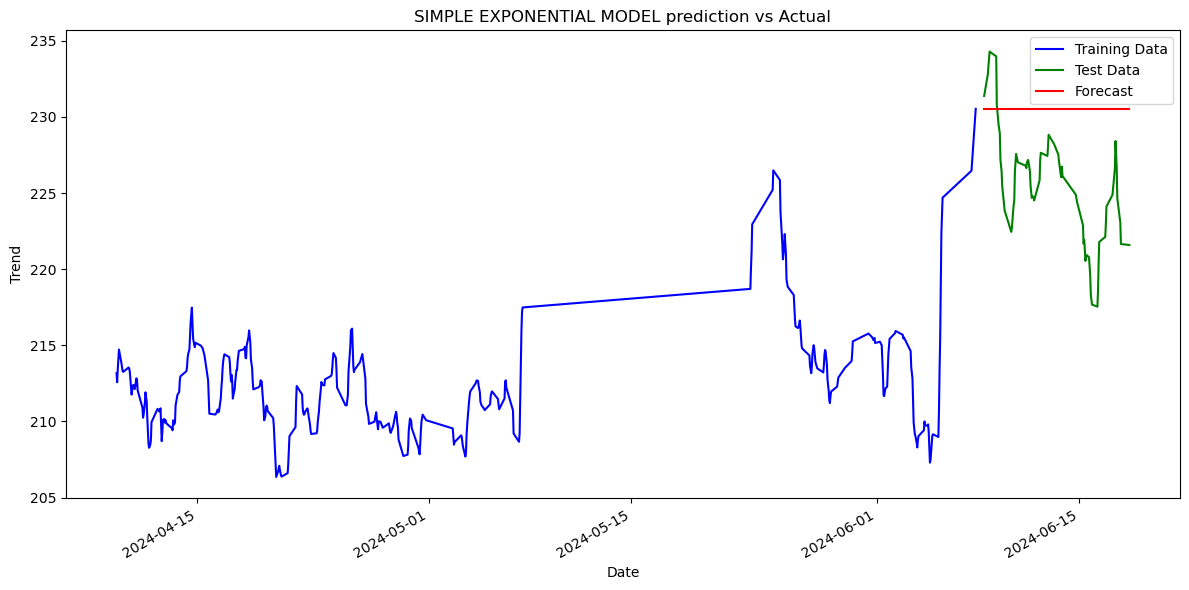

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(train['Timestamp'], train['Trend'], label='Training Data', color='blue')

plt.plot(test['Timestamp'], test['Trend'], label='Test Data', color='green')

plt.plot(test['Timestamp'], forecaste1, label='Forecast', color='red')

plt.title('SIMPLE EXPONENTIAL MODEL prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend() 

fig = plt.gcf()
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

In [52]:
plot_forecasts(forecaste1,'simple exponential model')

In [53]:
Holt_model = Holt(train["Trend"]).fit(optimized = True)
forecaste2 = Holt_model.forecast(len(test))

In [54]:
test_mse2 = mean_squared_error(test['Trend'], forecaste2)
print(f'Test Mean Squared Error: {test_mse2}')

Test Mean Squared Error: 6376.303441861402


In [55]:
plot_forecasts(forecaste2,'linear exponential model')